In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt

from sklearn.metrics import roc_curve, auc, roc_auc_score

from utils import combine_metadata, read_csv
from plot import plot_train_val_test_dis, plot_roc, plot_roc_with_thres, plot_confusion_matrix
from evaluation import evaluation_metrics, to_labels, optimal_threshold_tuning

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'DejaVu Sans','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20


//anaconda/envs/tflearn/lib/python3.5/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Question 1
Determine ground-truth labels from the metadata and merge the two data dumps for analysis (expected content in hand-in: code)

## 1(a) Load metadata, combine them and sort the rows by claim id numbers

In [2]:
meta_data = combine_metadata(path='../data/metadata/')
meta_data.head()

The combined metadata has shape:  (199827, 11)


,Unnamed: 0,claim_id,labour_amt,line_num,make,model,operation,part,part_price,poi,year
196017,NaN,0.0,110.000005,1.0,Volkswagen,Tiguan,replace,bbumper,266.600006,Rear Centre,2010.0
82272,NaN,1.0,114.999998,3.0,Peugeot,307,replace,blwing,337.709991,Rear Left,2003.0
72698,NaN,1.0,55.000001,2.0,Peugeot,307,repair,bldoor,NaN,Rear Left,2003.0
136570,NaN,1.0,55.000002,1.0,Peugeot,307,replace,bbumper,308.920013,Rear Left,2003.0
146647,NaN,2.0,115.000007,1.0,Volkswagen,Vw,replace,fbumper,294.000000,Front Centre,2007.0


### 1(b) We need to check the ground truth label in the meta data

In [3]:
ground_truth_label = pd.unique(meta_data.operation)
print('The ground truth labels in the meta data are {}'.format(ground_truth_label))

The ground truth labels in the meta data are ['replace' 'repair']


### 1(c) Check if line_num is empty. If it is the case, then we will label operation as undamaged

In [4]:
meta_data[meta_data.line_num.isnull()]

,Unnamed: 0,claim_id,labour_amt,line_num,make,model,operation,part,part_price,poi,year


In [5]:
meta_data.describe()

,claim_id,labour_amt,line_num,part_price,year
count,199827.000000,199827.000000,199827.000000,60362.000000,199552.000000
mean,50107.286598,131.065815,1.974208,285.147440,2006.383855
std,28861.165709,119.119590,1.288588,153.201825,4.000030
min,0.000000,-49.999993,1.000000,0.200000,1955.000000
25%,25146.500000,55.000002,1.000000,166.580002,2004.000000
50%,50208.000000,105.000001,2.000000,267.000000,2007.000000
75%,75119.000000,175.000000,2.000000,374.660004,2009.000000
max,99999.000000,13660.000306,10.000000,2365.000000,2017.000000


**We note that there is no NaNs in the 'line_num' column. Therefore, we will proceed without making any change to the table.**

## 1(d) Load Classifier output file 

In [6]:
classifier_file = read_csv(path='../data/', filename='classifier_output.csv')
classifier_file.head()

The file has shape:  (1000000, 4)


,claim_id,part,urr_score,set
0,0,fbumper,0.464102,0
1,0,bbumper,0.680342,0
2,0,bldoor,NaN,0
3,0,brdoor,NaN,0
4,0,frdoor,NaN,0


## 1(e) Merge two data - Meta data and Output classifier

In [7]:
# Merge the two data on columns 'claim_id' and 'part'. When merging on these two columns, 
# we will obtain the ground truth label from the meta data using the column 'operation'
merge_data = pd.merge(meta_data, classifier_file, on=['claim_id','part'])
merge_data.head()

,Unnamed: 0,claim_id,labour_amt,line_num,make,model,operation,part,part_price,poi,year,urr_score,set
0,NaN,0.0,110.000005,1.0,Volkswagen,Tiguan,replace,bbumper,266.600006,Rear Centre,2010.0,0.680342,0
1,NaN,1.0,114.999998,3.0,Peugeot,307,replace,blwing,337.709991,Rear Left,2003.0,0.979714,0
2,NaN,1.0,55.000001,2.0,Peugeot,307,repair,bldoor,NaN,Rear Left,2003.0,0.050809,0
3,NaN,1.0,55.000002,1.0,Peugeot,307,replace,bbumper,308.920013,Rear Left,2003.0,0.790558,0
4,NaN,2.0,115.000007,1.0,Volkswagen,Vw,replace,fbumper,294.000000,Front Centre,2007.0,0.599913,0


## Concluding Remarks for Question 1

<span style="color:blue"> ** It is important to note that here since the metadata is used to train the Undamaged-Repair-Replace (URR) classifier and we do not have label for undamaged parts, this means we are basically dealing with only a binary classifier. That is URR classifier is trained with repair and replace data only**</span>.

___


# Question 2
Analyse the performance of the classifiers (expected content in hand-in: code, 2-5 bullet-points and 1-3 tables/figures)

### First we are going to analyse the combined data created in question 1

In [8]:
# Extract only important information from merge_data
# Operation is the ground truth label (ytrue)
# Urr_score is the prediction from the classifier (ypred)
comparison_table_ = merge_data[['claim_id', 'operation', 'urr_score','set']]
print(comparison_table_.shape)
comparison_table_.head()


(199827, 4)


,claim_id,operation,urr_score,set
0,0.0,replace,0.680342,0
1,1.0,replace,0.979714,0
2,1.0,repair,0.050809,0
3,1.0,replace,0.790558,0
4,2.0,replace,0.599913,0


### We need to check if there is any Null Values in the prediction
If the classifier score is missing, that means that the part was not identified by the AI in the images provided. 

In [9]:
nan_pred = comparison_table_[comparison_table_.urr_score.isnull()==True]
print('The number of prediction that is missing: {}'.format(nan_pred.shape[0]))

# We remove the nans from the data to be able to analyse the prediction
comparison_table = comparison_table_.dropna(subset=['urr_score'])
print('The final merge table has shape: {}'.format(comparison_table.shape))

The number of prediction that is missing: 8635
The final merge table has shape: (191192, 4)


### 2(a) Find the number of samples in training, validation and test set

In the metadata, we found that there is only two classes of labels: Repair and Replace. There is no 'Undamage' class. It is important to understand the number of samples in the training, validation and test set. Also, we want to know whether we have a fairly balanced classes of either 'repair' or 'replace' in the data.

In [10]:
unique_class = pd.unique(comparison_table.operation)
print('The Ground Truth Class labels are: {}'. format(unique_class))

The Ground Truth Class labels are: ['replace' 'repair']


In [11]:
training_set = comparison_table[comparison_table.set==0]
validation_set = comparison_table[comparison_table.set==1]
testing_set = comparison_table[comparison_table.set==2]

print('The total number of training samples: ',training_set.shape[0])
print('The number of "Repair" class is {} and the number of "Replace" class is {}\n'
      .format(training_set[training_set.operation=='repair'].shape[0], training_set[training_set.operation=='replace'].shape[0]))

print('The total number of validation samples: ',validation_set.shape[0])
print('The number of "Repair" class is {} and the number of "Replace" class is {}\n'
      .format(validation_set[validation_set.operation=='repair'].shape[0], validation_set[validation_set.operation=='replace'].shape[0]))

print('The total number of testing samples: ',testing_set.shape[0])
print('The number of "Repair" class is {} and the number of "Replace" class is {}\n'
      .format(testing_set[testing_set.operation=='repair'].shape[0], testing_set[testing_set.operation=='replace'].shape[0]))


The total number of training samples:  153195
The number of "Repair" class is 105422 and the number of "Replace" class is 47773

The total number of validation samples:  18950
The number of "Repair" class is 12989 and the number of "Replace" class is 5961

The total number of testing samples:  19047
The number of "Repair" class is 13198 and the number of "Replace" class is 5849




<span style="color:blue"> We can easily notice that we are dealing with a highly imbalanced data set. This mean URR classifier has been trained on a highly imbalanced data, therefore, the output of the classifier model might be biased towards the large sample data, that is the Repair class.<span>


## 2(b) Let's analyse the classifier output

In [12]:
# Select the full data (train, val, test) and extract the classifier output by their true label
repair_distn = comparison_table[comparison_table.operation == 'repair'].urr_score
replace_distn = comparison_table[comparison_table.operation == 'replace'].urr_score

In [13]:
# The table shows the statistics of the output score for the Repair Class
repair_distn.describe()

count    131609.000000
mean          0.401393
std           0.154728
min           0.000006
25%           0.299955
50%           0.397740
75%           0.489298
max           0.999236
Name: urr_score, dtype: float64

In [14]:
# The table shows the statistics of the output score for the Replace Class
replace_distn.describe()

count    59583.000000
mean         0.663172
std          0.186584
min          0.005298
25%          0.542234
50%          0.679278
75%          0.804636
max          0.999491
Name: urr_score, dtype: float64

## 2(c) Plot the probability density of the two classes
Each bin will display the bin's raw count divided by the total number of counts and the bin width 
density = counts / ( sum(counts) * np.diff(bins) )

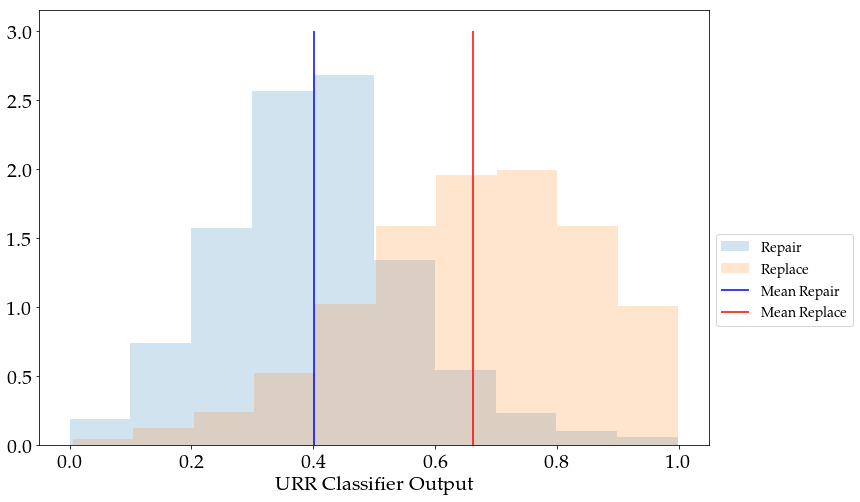

In [15]:
# Let's plot both distributions of the whole data
plt.figure(figsize=figSize)
plt.vlines(repair_distn.mean(),ymin=0,ymax=3, color='b',label = 'Mean Repair')
plt.vlines(replace_distn.mean(),ymin=0,ymax=3, color='r',label = 'Mean Replace')

plt.hist(repair_distn, density=True, alpha=0.2, label = 'Repair')
plt.hist(replace_distn, density=True, alpha=0.2, label = 'Replace')

plt.xlabel('URR Classifier Output', fontsize=fontSize)
plt.tick_params(axis='both', labelsize=fontSize)
plt.legend(loc="best",prop={'size':14},bbox_to_anchor=(1,0.5))
plt.show()

Let's check the consistency of the output score of the classifier for the training, validation and test set.

In [16]:
# Select train, val, test data and extract the classifier output by their true label
repair_train_distn = training_set[training_set.operation == 'repair'].urr_score
replace_train_distn = training_set[training_set.operation == 'replace'].urr_score

repair_val_distn = validation_set[validation_set.operation == 'repair'].urr_score
replace_val_distn = validation_set[validation_set.operation == 'replace'].urr_score

repair_test_distn = testing_set[testing_set.operation == 'repair'].urr_score
replace_test_distn = testing_set[testing_set.operation == 'replace'].urr_score

print('The mean training distribution of repair class is {} and replace class is {}'\
      .format(np.mean(repair_train_distn),np.mean(replace_train_distn)))
print('The mean validation distribution of repair class is {} and replace class is {}'\
      .format(np.mean(repair_val_distn),np.mean(replace_val_distn)))
print('The mean testing distribution of repair class is {} and replace class is {}'.\
      format(np.mean(repair_test_distn),np.mean(replace_test_distn)))

The mean training distribution of repair class is 0.401017070108526 and replace class is 0.6661113571061587
The mean validation distribution of repair class is 0.40469949617832773 and replace class is 0.653970470627299
The mean testing distribution of repair class is 0.40113744241843013 and replace class is 0.6485369827641007


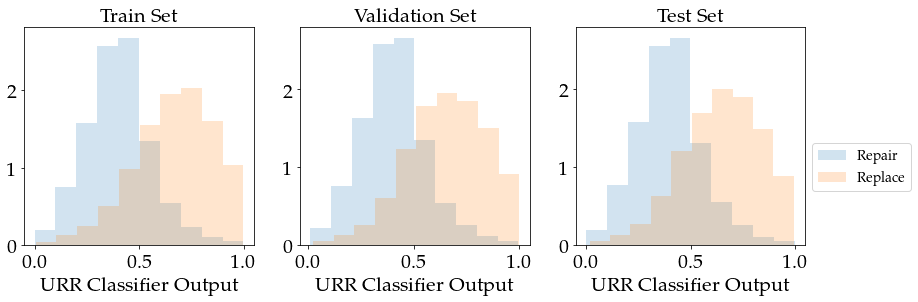

In [17]:
plot_train_val_test_dis(repair_train_distn,replace_train_distn, repair_val_distn,replace_val_distn,\
                      repair_test_distn, replace_test_distn)

## 2(d) Analyse the performance of the classifier

### Convert ground truth label to numbers

Since it is a binary classifer, we will convert repair to 0 and replace to 1.

In [18]:
# Map repair --> 0 and replace ---> 1
mapping = {'repair': 0, 'replace': 1}
predicted_table = comparison_table.replace({'operation': mapping})
print('The number of repair samples is {} and the number of replace sample is {}'\
      .format(predicted_table[predicted_table.operation==0].shape[0],predicted_table[predicted_table.operation==1].shape[0]))

# Change column names
predicted_table = predicted_table.rename(columns={'operation': 'ytrue', 'urr_score': 'ypred'})
predicted_table.head()

The number of repair samples is 131609 and the number of replace sample is 59583


,claim_id,ytrue,ypred,set
0,0.0,1,0.680342,0
1,1.0,1,0.979714,0
2,1.0,0,0.050809,0
3,1.0,1,0.790558,0
4,2.0,1,0.599913,0


In [19]:
# Define variables
# Choose test set to analyse prediction
y_true = predicted_table[predicted_table.set == 2].ytrue
y_prob = predicted_table[predicted_table.set == 2].ypred

The probability obtained from the URR classifier must be converted into a crisp class label. The decision for converting a predicted probability into a class label is governed by a parameter referred to as the <span style="color:blue">“threshold.”</span> A default value that is usually adopted for the threshold is 0.5 for normalized predicted probabilities in the range between 0 or 1.

For example, on a binary classification problem (repair or replace) with class labels 0 and 1, normalized predicted probabilities and a threshold of 0.5, then values less than the threshold of 0.5 are assigned to class 0 and values greater than or equal to 0.5 are assigned to class 1.

- <span style="color:blue"> Prediction < 0.5 = Class 0 or repair </span>
- <span style="color:blue"> Prediction >= 0.5 = Class 1 or replace </span>

By visual inspection of the probability density plots, we note that a proper threshold to use is 0.5 to evaluate the performance of the classifier.

In [20]:
# Convert probability vector into target vector
y_pred = to_labels(probs=y_prob, threshold=0.5)
y_pred.head()

23    1
28    1
29    0
30    0
40    0
Name: ypred, dtype: int64

The balanced-accuracy of the model is 0.7807426888301798
The Matthews correlation coefficient of the model is 0.5290024421442081


                   pre       rec       spe        f1       geo       iba       sup

     Repair       0.89      0.77      0.79      0.83      0.78      0.61     13198
    Replace       0.61      0.79      0.77      0.69      0.78      0.61      5849

avg / total       0.80      0.78      0.78      0.78      0.78      0.61     19047



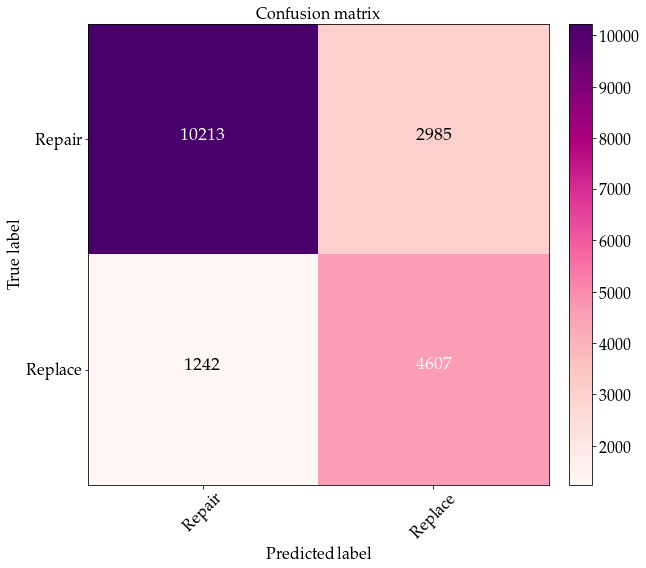

In [21]:
# Analysing the performance of the classifier based on various metrics dealing with imbalanced data
balance_accuracy, MCC, report, conf_mat = evaluation_metrics(y_true, y_pred, classes = ['Repair', 'Replace'])

## Concluding Remarks for Question 2

- The classifier is trained, validate and test on two classes: Repair and Replace
- We illustrate the number of samples in the training, validation and test set.


| Class       | Training set | Validation Set | Test Set | Total   |
| ----------- | ------------ | -------------- | -------- | ------- |
| **Repair**  | 105,422      |12,989          | 13,198   | 131,609 |
| **Replace** | 47,773       |5961            |5849      | 59,583  |
| **Total**   |153,195       |18,950          |19,047    |    -    |

</br>

- From the table, we can clearly note the class distributions are imbalanced. We have more examples of class 'repair' compared to class 'replace'. Training a classifier with such a data will result in a bias classifier. That is the trained model will favor the class with higher number of examples.

</br>

- We then analyse the output score of the URR classifier. To do so, we plot the probability density of the scores for the whole data and break that into training, validation and test set. We want to check if the prediction is fairly consistent between the different sets. On a visual perspective, from the plots we note the output distribution is fairly consistent among the three sets for the two classes (repair & replace) considered.

</br>

| Mean Score  | Entire data | Training set | Validation Set | Test Set|
| ----------- | ----------- | ------------ | -------------- | ------- |
| **Repair**  | 0.401       | 0.401        | 0.405          | 0.401   |
| **Replace** | 0.663       | 0.666        | 0.654          | 0.648   |   

</br>

- In the table, we illustrate the mean distribution of the entire data and break that in to the three sets considered for training, validation and test set. The mean values are consistent for each class.

</br>

- The probability density plot is useful generally as it provides a measure of the certainty or uncertainty of a prediction. It also provides additional granularity over just predicting the class label that can be interpreted.

</br>

- For the probability density plot, we note that the 'repair' and the 'replace' distribution overlap each other. This overlapping means that classifier struggles to decipher between the two classes. In ideal case we would want to see two peaks, at 0 and 1 for each respectively.

</br>

- The performance of the classifier is evaluated on balanced accuracy, MCC values, the classification report (recall, precision, Gmeans scores) and the confusion matrix. These metrics are suitable for imbalanced dataset. We note that there are certain misclassification occurring and obtained an accuracy of ~ 78%

___


# Question 3
Find the optimum thresholds to distinguish the undamaged/repair/replace classes. You are free to choose any objective here (accuracy, true positive rate, etc.) but make sure to justify your choice, and that the justification is sensible (expected content in hand-in: code, 2-5 bullet-points and 1-3 tables/figures)

## 3(a) Converting probabilities to class labels


The problem is that the default threshold may not represent an optimal interpretation of the predicted probabilities.

In this example, since we are dealing with a highly class imbalanced dataset, therefore there is the need to change the default decision threshold when interpreting the predictions of this model. As we have seen in the probability density plots, using a threshold 0.5 will cause severe misclassification.

We need to search a range of threshold values in order to find the best threshold, also known as <span style="color:blue">'thresholding'</span>

The process to do that is as follows:

- For each threshold in Thresholds:<br />
    a. Convert probabilities to Class Labels using the threshold.<br />
    b. Evaluate Class Labels.<br />
    c. If Score is Better than Best Score.<br />
    d. Adopt Threshold.<br />
- Use Adopted Threshold When Making Class Predictions on New Data.

## (i) Test 1: Optimal threshold for ROC curve
A Receiver Operating Characteristic curve (ROC) is a diagnostic plot that evaluates a set of probability predictions made by a model on a test dataset.

A set of different thresholds are used to interpret the true positive rate and the false positive rate of the predictions on the positive (minority) class, and the scores are plotted in a line of increasing thresholds to create a curve.

A diagonal line on the plot from the bottom-left to top-right indicates the “curve” for a no-skill classifier (predicts the majority class in all cases), and a point in the top left of the plot indicates a model with perfect skill.

The ROC Curve is a useful diagnostic tool for understanding the trade-off for different thresholds and the ROC AUC provides a useful number for comparing models based on their general capabilities.

We can then use the roc_auc_score() function to calculate the true-positive rate and false-positive rate for the predictions using a set of thresholds that can then be used to create a ROC Curve plot.

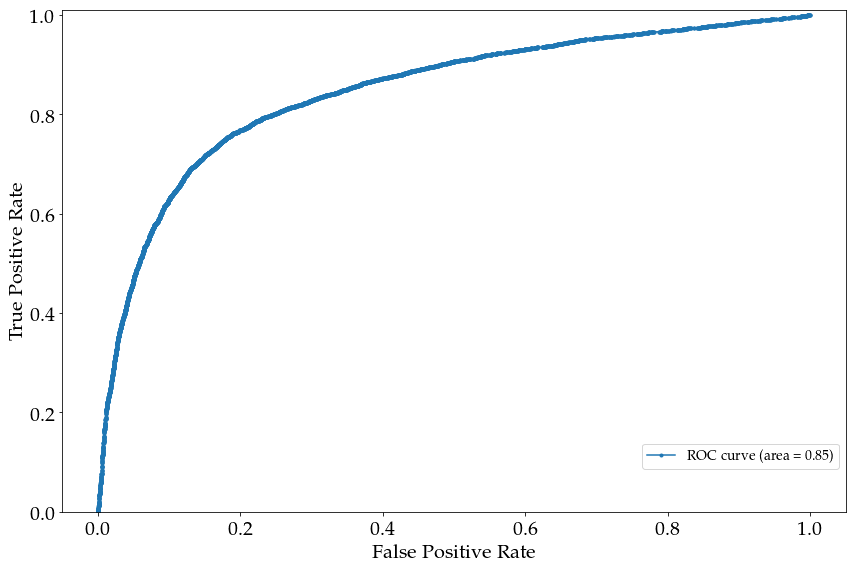

In [22]:
# Define metrics to be used
# Use Area under ROC curve and plot the ROC curve
y_prob = predicted_table[predicted_table.set == 2].ypred
auc    = roc_auc_score(y_true,y_prob)
fpr, tpr, thresholds  = roc_curve(y_true, y_prob, pos_label=1)
plot_roc(fpr, tpr, auc)

We can note that there are a number of points or thresholds close to the top-left of the plot.

**Which threshold is optimal?**


Firstly, the true positive rate is called the Sensitivity. The inverse of the false-positive rate is called the Specificity.

- Sensitivity = TruePositive / (TruePositive + FalseNegative)
- Specificity = TrueNegative / (FalsePositive + TrueNegative)

Where:

- Sensitivity = True Positive Rate
- Specificity = 1 – False Positive Rate

The **Geometric Mean** or **G-Mean** is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

- G-Mean = sqrt(Sensitivity * Specificity)

## First approach based on ROC-curve and Gmeans
Test the model with each threshold returned from the call roc_auc_score() and select the threshold with the largest G-Mean value. Once calculated, we can locate the index for the largest G-mean score and use that index to determine which threshold value to use.

In [23]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold = %f, G-Mean = %.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold = 0.519294, G-Mean = 0.786


Best Threshold=0.519294, G-Mean=0.786


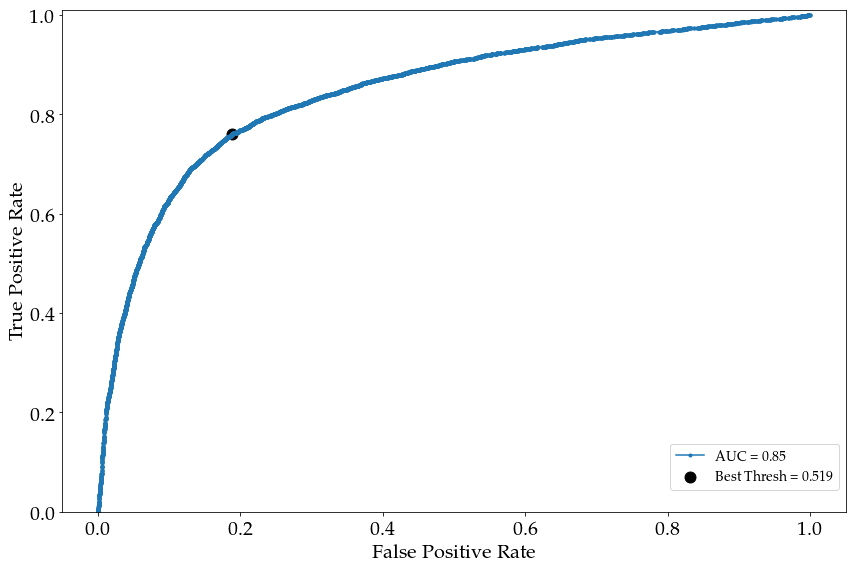

In [24]:
# The threshold is then used to locate the true and false positive rates, then this point is drawn on the ROC Curve.
# We can see that the point for the optimal threshold is a large black dot and it appears to be closest to the 
# top-left of the plot.

plot_roc_with_thres(fpr, tpr, auc, thresholds)


## (ii) Test 2: Optimal Threshold Tuning

In this example, we can define a set of thresholds and then evaluate predicted probabilities based on a metrics to find and select the optimal threshold.

In [25]:
# Let us define a set of thresholds to evaluate the probabilities
thresholds = np.arange(0, 1, 0.001)

We need to convert each probabilities to a labels when varying the threshold. This can be achieved using the function **to_label()**. We will used the **balanced_accuracy** and **Geometric Mean** metrics to evaluate the resulting labels based on a specific thresholds using the function **optimal_threshold_tuning()**. 

In [26]:
b_accuracy, gmean_scores = optimal_threshold_tuning(y_prob, y_true, thresholds)


Optimal Threshold = 0.524 based on Balanced Accuracy Score = 0.786
Optimal Threshold = 0.519 based on GMeans-Score = 0.785


## Concluding Remarks for Question 3

- In this question, we test two approaches: (i) Based on ROC curves and (ii) Optimal thresholding approach. To evaluate the performance of the classifier, we used metrics such as the balanced accuracy and geometric mean scores. These metrics deals with high imbalanced data set. 

</br>

- In the table below, we summarise all the results:

| Methods       | Thresholds  | Balanced Accuracy | Gmeans | 
| ------------- | ----------- | ----------------- | ------ | 
| Default       | **0.5**     | 0.78              |0.78    | 
| ROC curve     |**0.519**    | -                 |0.786   |
| Thresh tuning |**0.524**    |0.786              |-       |
| Thresh tuning |**0.519**    | -                 |0.785   |

___


# Question 6

You are now tasked with predicting the cost of performing the operations for a particular claim as a function of the URR scores and the claim data. How would you design a system that can predict these costs? Which metadata fields would you use? Would you also require any additional data (not provided in the data dump) that will help you improve the accuracy of your estimate? (expected content in hand-in: 5-10 bullet-points)

- The input data that will be used are shown in the table. In these inputs, note that in the metadata these input parameters are in 'text/word/string' format. We therefore need to embed/encode these 'word' into categorical variables (techniques like embedding matrix/vector can be used). Therefore, we will have a table with input features having only numbers (float or integers).

</br>

| X-Input |      |      |      |       |       |          Y-Output        |
| -------------------------------------------- | ------------------------ |
| make | model | year | poi | part | URR_score | <span style="color:blue"> part_price </span>| <span style="color:blue">labour_amt</span>  |
|   -  |   -   |   -  |  -  |   -  |    -      |     -      |      -      |
|   -  |   -   |   -  |  -  |   -  |    -      |     -      |      -      |

- A preprocessing step needs to be done, for instance, check for null values or missing values. Filter out unnecessary rows. We will also change the 'year' features to 'age_of_vehicle' by using this equation. Age of vehicle = 2021 - year. Using the 'set' column in the classifier output data, the table will be split into training, validation, and test set. 0 --> train, 1--> validation set and 2 --> test set. Data visualisation is also important and we can categorised the data into parts of the vehicles or brand/model and see if there is any correlation between the price of repair, brand, age ...

</br>

- A multi-layer neural network (Deep Neural Network), with several hidden layers can be used. The input will consist of various data about the car and the prediction of the URR classifier as selected in the table above. The output of the deep neural network will be the cost of the part to be replaced and the labour amount. Therefore, we will have two outputs from the network model.

</br>

- Use Various evaluation metrics to analyse the performance of the model, for instance Root Mean Square Error(RMSE). Also various network can be used and compared.

</br>

- The price of the car at present time. It is important to know this feature. For example, if the price of the cost of repair is greater than the actual price of the car, then it not optimal to proceed with a repair. Another important data that will severely vary the prediction of the cost is the severity measure of damage of the part. For instance, if a part is classified to be repair, it would be good to know how damage is it - low, medium or high. Then the price of the cost will heavily be dependent on this feature.





